In [118]:
from pylab import *
import matplotlib.pyplot as plt
import sys
import caffe
import os
import h5py
from sklearn import preprocessing
caffe_root = '/home/nikhil/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

%matplotlib inline
plt.style.use('seaborn-poster')

caffe.set_device(1)
caffe.set_mode_gpu()
# Take care with the paths -defaults ones from protobuf are not correct. Need to change snapshot and train / test data paths 

In [117]:

plt.style.available


[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

In [2]:
import tables as tb
import collections

def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]        
    data.close()
    return X

def extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers):
    os.chdir(os.path.dirname(net_file))
    net = caffe.Net(net_file, model_file, caffe.TEST)        
    
    #print net.blobs.items()[0]
    #print net.blobs.items()[1]
    
    #Get weights    
    layer_list = weight_layers
    wt_dict = collections.OrderedDict()
    for l, name in enumerate(net._layer_names):            
        if name in layer_list:
            wt_dict[name] = net.layers[l].blobs[0].data
    
    BATCH_SIZE = batch_size        
    N = load_data(data_path, input_nodes[0]).shape[0]
    iters = int(np.ceil(N / float(BATCH_SIZE)))
    code_layer = net.blobs[encoding_layer]
    out_shape = code_layer.data.shape    
    X_out = np.zeros(shape=(N, out_shape[1]))        
    #print 'X_out.shape: {}'.format(X_out.shape)
        
    X_list = []
    data_layers = []
    for i, input_node in enumerate(input_nodes):
        X_list.append(load_data(data_path, input_node))
        #print net.blobs[input_node].shape
        
        data_layers.append(net.blobs[input_node])    
        #print 'X_list shape: {}'.format(X_list[i].shape)
        #print 'data_layers shape: {}'.format(data_layers[i].data.shape)
        data_layers[i].reshape(BATCH_SIZE, X_list[i].shape[1]) # TODO: only works for 2-D inputs
        #print 'data_layers shape: {}'.format(data_layers[i].data.shape)
    
     
    net.reshape()            
    #print 'Extracting features from data...'
    
    for i in xrange(iters):
        print '.',
        for m, X in enumerate(X_list):
            X_b = X[i * BATCH_SIZE: (i+1) * BATCH_SIZE,:]
            batch_sampx = X_b.shape[0]
            # Pad last batch with zeros
            if X_b.shape[0] < BATCH_SIZE:
                #print 'Zero-padding last batch with {} rows'.format(BATCH_SIZE-X_b.shape[0])
                X_b = np.vstack((X_b,np.zeros((BATCH_SIZE-X_b.shape[0],X_b.shape[1]))))                       
            
            data_layers[m].data[...] = X_b
            
        net.forward()                
        X_out[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer.data[0:batch_sampx,:].copy()
        
    return {'X_out':X_out, 'wt_dict':wt_dict}

In [3]:
from caffe import layers as L, params as P

def adninet_siamese(hdf5, batch_size, node_sizes, dr, lr):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    n.X_L,n.X_R,n.y_traj  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5, ntop=3) #orig
    
        
    #-------Hidden Layers-----------#
    #ff layers Left    
    n.ff_L1 = L.InnerProduct(n.X_L, num_output=node_sizes['ff1'], weight_filler=dict(type='xavier'), bias_filler=dict(type='constant'), 
                             param=[dict(name="ff1_w", lr_mult=lr['ff1']),dict(name="ff1_b", lr_mult=1)]) #param list includes weight and bias configs
    n.NLinEnL1 = L.TanH(n.ff_L1, in_place=True)
    n.dropL1 = L.Dropout(n.ff_L1, in_place=True,dropout_param=dict(dropout_ratio=dr['ff1']))
    
#     n.ff_L2 = L.InnerProduct(n.ff_L1, num_output=node_sizes['ff2'], weight_filler=dict(type='xavier'), bias_filler=dict(type='constant'), 
#                              param=[dict(name="ff2_w", lr_mult=lr['ff2']),dict(name="ff2_b", lr_mult=1)]) #param list includes weight and bias configs
#     n.NLinEnL2 = L.TanH(n.ff_L2, in_place=True)
#     n.dropL2 = L.Dropout(n.ff_L2, in_place=True,dropout_param=dict(dropout_ratio=dr['ff2']))
    
    n.ff_L3 = L.InnerProduct(n.ff_L1, num_output=node_sizes['ff3'], weight_filler=dict(type='xavier'), bias_filler=dict(type='constant'), 
                             param=[dict(name="ff3_w", lr_mult=lr['ff3']),dict(name="ff3_b", lr_mult=1)]) #param list includes weight and bias configs
    n.NLinEnL3 = L.TanH(n.ff_L3, in_place=True)
    n.dropL3 = L.Dropout(n.ff_L3, in_place=True,dropout_param=dict(dropout_ratio=dr['ff3']))
    
    #ff layers Right    
    n.ff_R1 = L.InnerProduct(n.X_R, num_output=node_sizes['ff1'], weight_filler=dict(type='xavier'), bias_filler=dict(type='constant'), 
                             param=[dict(name="ff1_w", lr_mult=lr['ff1']),dict(name="ff1_b", lr_mult=1)])
    n.NLinEnR1 = L.TanH(n.ff_R1, in_place=True)
    n.dropR1 = L.Dropout(n.ff_R1, in_place=True,dropout_param=dict(dropout_ratio=dr['ff1']))
    
#     n.ff_R2 = L.InnerProduct(n.ff_R1, num_output=node_sizes['ff2'], weight_filler=dict(type='xavier'), bias_filler=dict(type='constant'), 
#                              param=[dict(name="ff2_w", lr_mult=lr['ff2']),dict(name="ff2_b", lr_mult=1)]) #param list includes weight and bias configs
#     n.NLinEnR2 = L.TanH(n.ff_R2, in_place=True)
#     n.dropR2 = L.Dropout(n.ff_R2, in_place=True,dropout_param=dict(dropout_ratio=dr['ff2']))
    
    n.ff_R3 = L.InnerProduct(n.ff_R1, num_output=node_sizes['ff3'], weight_filler=dict(type='xavier'), bias_filler=dict(type='constant'), 
                             param=[dict(name="ff3_w", lr_mult=lr['ff3']),dict(name="ff3_b", lr_mult=1)]) #param list includes weight and bias configs
    n.NLinEnR3 = L.TanH(n.ff_R3, in_place=True)
    n.dropR3 = L.Dropout(n.ff_R3, in_place=True,dropout_param=dict(dropout_ratio=dr['ff3']))
    

    #-------Output Layers-----------#    
    n.loss = L.ContrastiveLoss(n.ff_L3, n.ff_R3, n.y_traj, contrastive_loss_param=dict(margin=1))            

    return n.to_proto()

In [100]:
from caffe.proto import caffe_pb2
### define solver
def adni_solver(train_net_path, test_net_path, solver_configs, baseline_dir, exp_name):    
    s = caffe_pb2.SolverParameter()
    
    # Set a seed for reproducible experiments:
    # this controls for randomization in training.
    s.random_seed = 0xCAFFE

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    s.test_net.append(test_net_path)
    s.test_interval = 500  # Test after every 500 training iterations.
    s.test_iter.append(30) # Test on 100 batches each time we test.

    s.max_iter = 10000     # no. of times to update the net (training iterations)

    # EDIT HERE to try different solvers
    # solver types include "SGD", "Adam", and "Nesterov" among others.
    #s.solver_type = "Nesterov"

    # Set the initial learning rate for SGD.
    #s.base_lr = 0.00001  # EDIT HERE to try different learning rates
    s.base_lr = solver_configs['base_lr']
    # Set momentum to accelerate learning by
    # taking weighted average of current and previous updates.
    #if not s.type == "AdaGrad":
    #    s.momentum = 0.9
    # Set `lr_policy` to define how the learning rate changes during training.
    # This is the same policy as our default LeNet.
    s.lr_policy = "step"
    s.stepsize = 100000
    s.gamma = 0.5
    #s.power = 0.75
    # EDIT HERE to try the fixed rate (and compare with adaptive solvers)
    # `fixed` is the simplest policy that keeps the learning rate constant.
    # s.lr_policy = 'fixed'
    
    # Set weight decay to regularize and prevent overfitting
    #s.weight_decay = 1e-3
    s.weight_decay = solver_configs['wt_decay']
    
    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.
    # We'll snapshot every 5K iterations -- twice during training.
    s.snapshot = 10000
    s.snapshot_prefix = baseline_dir + 'NN_snaps/{}'.format(exp_name)

    # Train on the GPU
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    return s

In [101]:
%%time
def run_caffe(solver,niter,batch_size):
    # each output is (batch size, feature dim, spatial dim)
    #print [(k, v.data.shape) for k, v in solver.net.blobs.items()]
    test_interval = 1000
    test_iter = 20
        
    #n_feat = solver.test_nets[0].blobs['data'].data.shape[1]
    # losses will also be stored in the log
    test_acc = np.zeros(int(np.ceil(niter / test_interval)))
    train_loss = np.zeros(niter)
    test_loss = np.zeros(int(np.ceil(niter / test_interval)))  

    #output = zeros((niter, batch_size))
    #solver.restore()
    #the main solver loop
    for it in range(niter):
        #solver.net.forward()
        solver.step(1)  # SGD by Caffe    
        # store the train loss        
        train_loss[it] = solver.net.blobs['loss'].data        

        if it % test_interval == 0:        
            t_loss = 0            
            correct = 0
            for test_it in range(test_iter):
                solver.test_nets[0].forward()                                
                t_loss += solver.test_nets[0].blobs['loss'].data                                    
                test_loss[it // test_interval] = t_loss/(test_iter)
                
            print 'Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                it, train_loss[it], np.sum(train_loss)/it, test_loss[it // test_interval])
                
        
        perf = {'train_loss':train_loss[::test_interval],'test_loss':test_loss}
        
                
    return perf

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [102]:
niter=200000
batch_size=25

lr = {'ff1':1,'ff2':1, 'ff3':1}
dr = {'ff1':0.25,'ff2':0,'ff3':0}
node_sizes = {'ff1':50,'ff2':10,'ff3':2}
solver_configs = {'base_lr':1e-5, 'wt_decay':1e-4}

simulation = False
start_fold = 1
n_folds = 10

if simulation:
    # Define data paths
    baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/simulations/'
    train_filename_txt = baseline_dir + 'input_data/train_C688.txt'
    test_filename_txt = baseline_dir + 'input_data/train_C688.txt'
    train_filename_hdf = baseline_dir + 'input_data/sim_traj_train_2.h5'
    test_filename_hdf = baseline_dir + 'input_data/sim_traj_train_2.h5'
    
    # Define Net (examples: 'ADNI_AE_train.prototxt', 'ADNI_FF_train.prototxt')
    train_net_path = baseline_dir + 'input_data/ADNI_FF_train.prototxt'
    test_net_path = baseline_dir + 'input_data/ADNI_FF_test.prototxt'    
    with open(train_net_path, 'w') as f:            
            f.write(str(adninet_siamese(train_filename_txt, batch_size, node_sizes, dr, lr)))
    with open(test_net_path, 'w') as f:    
        f.write(str(adninet_siamese(test_filename_txt, batch_size, node_sizes, dr, lr)))
    
    # Define Solver    
    solver_path = baseline_dir + 'input_data/adninet_siamese_solver.prototxt'
    with open(solver_path, 'w') as f:
        f.write(str(adni_solver(train_net_path, test_net_path, solver_configs, baseline_dir, exp_name)))

    solver = caffe.NesterovSolver(solver_path)

    # Run caffe
    results = run_caffe(solver,niter,batch_size)    

else: 
    baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/exp_setup/'
    train_filename_txt = baseline_dir + 'NN_setups/train_C688.txt'
    test_filename_txt = baseline_dir + 'NN_setups/test_C688.txt'
    train_filename_hdf = baseline_dir + 'NN_setups/Traj_split_Exp6_MCI_ADNI2_ADAS13_BL_m06_scaled_siamese_fold_{}_train.h5'
    test_filename_hdf = baseline_dir + 'NN_setups/Traj_split_Exp6_MCI_ADNI2_ADAS13_BL_m06_scaled_siamese_fold_{}_test.h5'
    train_loss = []
    test_loss = []
    for fid in np.arange(start_fold,n_folds+1,1):
        print 'fold: {}'.format(fid)
        exp_name = 'adni_siamese_fold_{}'.format(fid)
    
        with open(train_filename_txt, 'w') as f:
                f.write(train_filename_hdf.format(fid) + '\n')    

        with open(test_filename_txt, 'w') as f:
                f.write(test_filename_hdf.format(fid) + '\n')  

        # Define Net (examples: 'ADNI_AE_train.prototxt', 'ADNI_FF_train.prototxt')
        train_net_path = baseline_dir + 'NN_setups/ADNI_FF_train.prototxt'
        test_net_path = baseline_dir + 'NN_setups/ADNI_FF_test.prototxt'

        with open(train_net_path, 'w') as f:            
            f.write(str(adninet_siamese(train_filename_txt, batch_size, node_sizes, dr, lr)))

        with open(test_net_path, 'w') as f:    
            f.write(str(adninet_siamese(test_filename_txt, batch_size, node_sizes, dr, lr)))

        # Define Solver
        solver_path = baseline_dir + 'NN_setups/adninet_siamese_solver.prototxt'        
        with open(solver_path, 'w') as f:
            f.write(str(adni_solver(train_net_path, test_net_path, solver_configs, baseline_dir, exp_name)))

        solver = caffe.NesterovSolver(solver_path)

        # Run caffe
        results = run_caffe(solver,niter,batch_size)
        train_loss.append(results['train_loss'])
        test_loss.append(results['test_loss'])

fold: 1
Iteration: 0, train loss(batch, sum): (0.130109027028,inf), test loss: 0.153452708572
Iteration: 1000, train loss(batch, sum): (0.114135056734,0.17289295271), test loss: 0.15435673669
Iteration: 2000, train loss(batch, sum): (0.205113455653,0.17261110067), test loss: 0.153591145575
Iteration: 3000, train loss(batch, sum): (0.179995656013,0.173007356656), test loss: 0.152953779697
Iteration: 4000, train loss(batch, sum): (0.237661913037,0.172245547673), test loss: 0.153663900495
Iteration: 5000, train loss(batch, sum): (0.1599419415,0.171820379403), test loss: 0.152868973464
Iteration: 6000, train loss(batch, sum): (0.161148503423,0.171474202228), test loss: 0.153191697598
Iteration: 7000, train loss(batch, sum): (0.161944106221,0.171387016435), test loss: 0.153153413534
Iteration: 8000, train loss(batch, sum): (0.193629533052,0.171462254021), test loss: 0.152413123101
Iteration: 9000, train loss(batch, sum): (0.134067133069,0.171295098401), test loss: 0.152193068713
Iteration: 

In [44]:
a=range(10)
b=a[::2]
print a,b

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [0, 2, 4, 6, 8]


mode: train
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . mode: test
. . . . . . . . . . . . . . . . . . . .


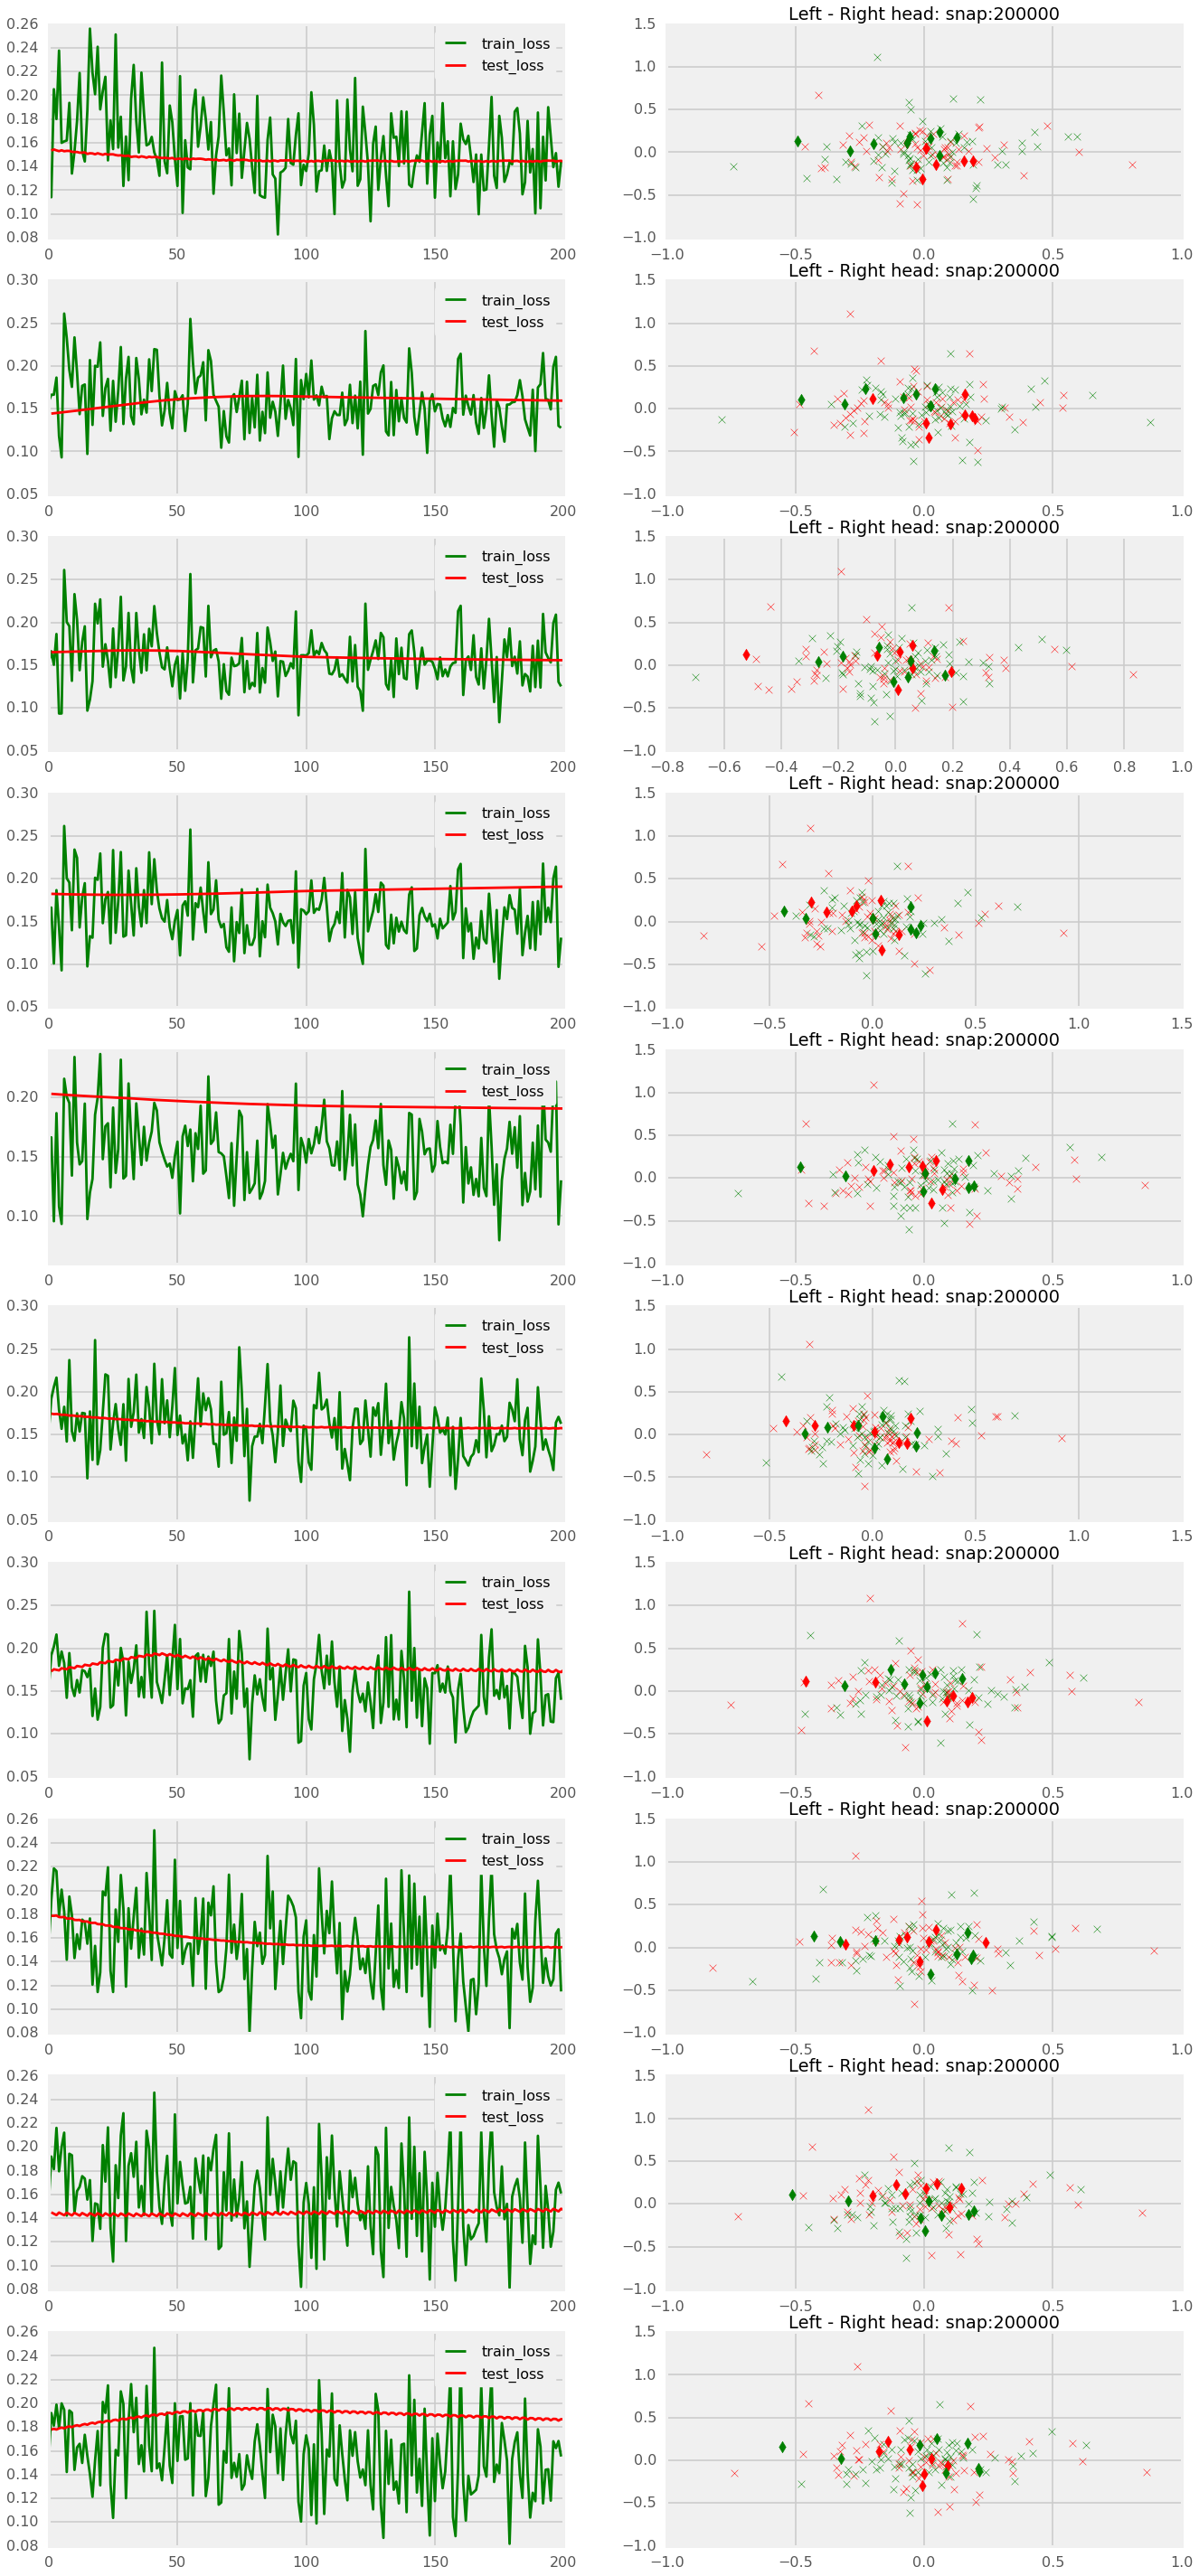

In [119]:
#n_folds=5
plt.rcParams['figure.figsize'] = (20, 5*n_folds)

snap_iter = 200000
rows = n_folds

#fid_snap_pair_list = [30000,20000,10000,10000,20000,10000,10000,10000,20000,40000]


for mode in ['train','test']:
    print 'mode: ' + mode
    if mode == 'train':
        if simulation:    
            MODEL_FILE = baseline_dir + 'input_data/ADNI_FF_train.prototxt'
        else:
            MODEL_FILE = baseline_dir + 'NN_setups/ADNI_FF_train.prototxt'
        test_hdf_path = train_filename_hdf
        CV_train_X = []
        CV_train_y = []
    elif mode =='test':    
        if simulation:    
            MODEL_FILE = baseline_dir + 'input_data/ADNI_FF_test.prototxt'
        else:
            MODEL_FILE = baseline_dir + 'NN_setups/ADNI_FF_test.prototxt'
        test_hdf_path = test_filename_hdf
                
        CV_test_X = []
        CV_test_y = []

    else:
        print 'unknown mode'


    #for snap, snap_iter in enumerate(snap_iter_list):
    for f, fid in enumerate(np.arange(1,n_folds+1,1)):
        #snap_iter = fid_snap_pair_list[f]
               
        PRETRAINED_FILE = baseline_dir + 'NN_snaps/adni_siamese_fold_{}_iter_{}.caffemodel'.format(fid,snap_iter)    
        
        net = caffe.Net(MODEL_FILE, PRETRAINED_FILE, caffe.TEST)    
        #labels = load_data(test_file_path,'y_labels')
        test_file_path = test_hdf_path.format(fid)
        labels = load_data(test_file_path,'y_traj')

        input_nodes = ['X_L','X_R']
        encoding_layer = 'ff_L3'
        weight_layers = 'ff_L3'
        test_run = extract_features(MODEL_FILE,PRETRAINED_FILE,test_file_path, input_nodes, batch_size, encoding_layer, weight_layers)
        feat_L = test_run['X_out']
        wt_L= test_run['wt_dict']

        encoding_layer = 'ff_R3'
        weight_layers = 'ff_R3'
        test_run = extract_features(MODEL_FILE,PRETRAINED_FILE,test_file_path, input_nodes, batch_size, encoding_layer, weight_layers)
        feat_R = test_run['X_out']
        wt_R= test_run['wt_dict']

        if mode == 'train':
            train_set_X = np.hstack((feat_L[labels!=-1],feat_R[labels!=-1]))
            CV_train_X.append(train_set_X)
            train_set_y = labels[labels!=-1]
            CV_train_y.append(train_set_y)
            marker = 'x'
            marker_size = 60
        elif mode =='test':    
            test_set_X = np.hstack((feat_L[labels!=-1],feat_R[labels!=-1]))
            CV_test_X.append(test_set_X)
            test_set_y = labels[labels!=-1]
            CV_test_y.append(test_set_y)
            marker = 'd'
            marker_size = 80
        else: 
            print 'unknown mode'

        #plots
        if mode == 'train':
            plt.subplot(rows,2,2*(f+1)-1)
            plt.plot(train_loss[f],'g',label='train_loss')
            test_epochs = np.arange(len(train_loss[f])/len(test_loss[f]),len(train_loss[f])+1,len(train_loss[f])/len(test_loss[f]))
            plt.plot(test_epochs,test_loss[f],'r',label='test_loss')
            plt.legend()
        
#         plt.scatter(feat_L[labels==0,0],feat_L[labels==0,1],color='r',marker=marker, s=marker_size, label='Traj_class=0')
#         plt.scatter(feat_L[labels==1,0],feat_L[labels==1,1],color='g',marker=marker, s=marker_size, label='Traj_class=1')
#         plt.scatter(feat_L[labels==-1,0],feat_L[labels==-1,1],color='b',label='Traj_class=fake')
#         plt.title('Left head: snap:{}'.format(snap_iter))
          #plt.legend()
#         plt.subplot(rows,3,3*(f+1)-1)
#         plt.scatter(feat_R[labels==0,0],feat_R[labels==0,1],color='r',marker=marker, s=marker_size, label='Traj_class=0')
#         plt.scatter(feat_R[labels==1,0],feat_R[labels==1,1],color='g',marker=marker, s=marker_size, label='Traj_class=1')
#         plt.scatter(feat_R[labels==-1,0],feat_R[labels==-1,1],color='b',label='Traj_class=fake')
          #plt.legend()
#         plt.title('Right head: snap:{}'.format(snap_iter))

        plt.subplot(rows,2,2*(f+1))
        plt.scatter(feat_L[labels==0,0] - feat_R[labels==0,0],feat_L[labels==0,1] - feat_R[labels==0,1],
                    color='r',marker=marker, s=marker_size,label='Traj_class=0')
        plt.scatter(feat_L[labels==1,0] - feat_R[labels==1,0],feat_L[labels==1,1] - feat_R[labels==1,1],
                    color='g',marker=marker, s=marker_size,label='Traj_class=1')
    #     plt.scatter(feat_R[labels==-1,0],feat_R[labels==-1,1],color='b',label='Traj_class=fake')
        #plt.legend()
        plt.title('Left - Right head: snap:{}'.format(snap_iter))

In [47]:
niter=30000
batch_size=25
lr = {'ff1':1,'ff2':1, 'ff3':1}
dr = {'ff1':0,'ff2':0,'ff3':0}
node_sizes = {'ff1':50,'ff2':50,'ff3':10}
solver_configs = {'base_lr':1e-4, 'wt_decay':1e-4}
fid: 0, train_X shape: (139, 20), test_X shape: (17, 20)
Acc: 0.705882352941, AUC:0.722222222222

SyntaxError: invalid syntax (<ipython-input-47-e363d22fe71e>, line 1)

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score as acc

#model_clf = LogisticRegression(penalty='l1',n_jobs=2,class_weight='balanced')
model_clf = SVC(class_weight='balanced',probability=True)
#model_clf = RFC(n_jobs=4,class_weight='balanced')

#hyper_params = {'C':[0.01,.1,1,10]} 
hyper_params = {'kernel':['linear','rbf'], 'C':[1,10]}
#hyper_params = {'n_estimators':[10,50,100],'min_samples_split':[2,4]}
scale_data = False #Scales features (z-score)            
feat_imp = False #The learned weights of each variable
CV_Acc_test = []
CV_AUC_test = []
CV_CM_test = []

for fid in np.arange(n_folds):
    train_X = CV_train_X[fid]
    train_y = CV_train_y[fid]
    test_X = CV_test_X[fid]
    test_y = CV_test_y[fid]
    
    print 'fid: {}, train_X shape: {}, test_X shape: {}'.format(fid,train_X.shape,test_X.shape)
    
    clf = innerCVLoop(model_clf,hyper_params,train_X, train_y)
    pred_y = clf.predict(test_X) #Specific label value
    pred_y_prob = clf.predict_proba(test_X) #Label probabilty (used for ROC)

    #Acc    
    CV_Acc_test.append(acc(pred_y,test_y)) 

    #Roc - Auc
    fpr, tpr, thresholds = roc_curve(test_y, pred_y_prob[:,1]) 
    CV_fpr_tpr = (fpr,tpr)
    CV_fpr_tpr_thrsh = thresholds
    CV_AUC_test.append(roc_auc_score(test_y, pred_y_prob[:,1]))

    #confusion matrix
    cm = confusion_matrix(pred_y,test_y)
    cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    CV_CM_test.append(cm_normalized)
    
    print 'Acc: {}, AUC:{}'.format(CV_Acc_test[fid], CV_AUC_test[fid])

print 'CV means'
print 'Acc: {}, AUC:{}'.format(np.mean(CV_Acc_test), np.mean(CV_AUC_test))
print 'Confusion Matrix: {}'.format(np.mean(np.array(CV_CM_test),axis=0))

fid: 0, train_X shape: (139, 4), test_X shape: (17, 4)
Acc: 0.352941176471, AUC:0.645833333333
fid: 1, train_X shape: (140, 4), test_X shape: (16, 4)
Acc: 0.4375, AUC:0.53125
fid: 2, train_X shape: (140, 4), test_X shape: (16, 4)
Acc: 0.375, AUC:0.5546875
fid: 3, train_X shape: (140, 4), test_X shape: (16, 4)
Acc: 0.5625, AUC:0.3984375
fid: 4, train_X shape: (140, 4), test_X shape: (16, 4)
Acc: 0.25, AUC:0.7265625
fid: 5, train_X shape: (141, 4), test_X shape: (15, 4)
Acc: 0.666666666667, AUC:0.339285714286
fid: 6, train_X shape: (141, 4), test_X shape: (15, 4)
Acc: 0.466666666667, AUC:0.375
fid: 7, train_X shape: (141, 4), test_X shape: (15, 4)
Acc: 0.266666666667, AUC:0.357142857143
fid: 8, train_X shape: (141, 4), test_X shape: (15, 4)
Acc: 0.533333333333, AUC:0.410714285714
fid: 9, train_X shape: (141, 4), test_X shape: (15, 4)
Acc: 0.333333333333, AUC:0.321428571429
CV means
Acc: 0.424460784314, AUC:0.46603422619
Confusion Matrix: [[ 0.40104618  0.59895382]
 [ 0.55611111  0.443888

In [12]:
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)   
    return clf

In [53]:
#create / organize real data
import pickle
scale_data = True

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/'
exp_setup_path = baseline_dir + 'exp_setup/CV_Traj_Exp6_MCI_demograph_ADNI2_ADAS13_MR_m06_CS_bl_traj_Traj.pkl'
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )
X_raw = exp_setup['X']
y = exp_setup['y']
kf = exp_setup['kf']
exp_name = exp_setup['exp_name']

if scale_data:        
    X = preprocessing.scale(X_raw)
else:
    X = X_raw
        
print exp_name
print X.shape, y.shape

Traj_Exp6_MCI_demograph
(156, 194) (156,)


In [54]:
#CV loop --> write to hdf per fold.   
fid = 1
save_data = False
traj_split = True

exp_name = 'Traj_split_Exp6_MCI_ADNI2_ADAS13_BL_m06_scaled'
for train, test in kf:
    #Train
    hdf_path_train = baseline_dir + 'exp_setup/NN_setups/{}_siamese_fold_{}_train.h5'.format(exp_name,fid)
    X_train = X[train]
    y_train = y[train]
        
    #Test
    hdf_path_test = baseline_dir + 'exp_setup/NN_setups/{}_siamese_fold_{}_test.h5'.format(exp_name,fid)
    X_test = X[test]
    y_test = y[test]    
    
    siameseData = prepareSiameseData(X_train, y_train, hdf_path_train, traj_split, save_data)
    siameseData = prepareSiameseData(X_test, y_test, hdf_path_test, traj_split, save_data)
    
    fid+=1
    

Shapes X_T1 :(139, 97), X_T2:(139, 97), y_traj:(139,)
Shapes X_T1 :(17, 97), X_T2:(17, 97), y_traj:(17,)
Shapes X_T1 :(140, 97), X_T2:(140, 97), y_traj:(140,)
Shapes X_T1 :(16, 97), X_T2:(16, 97), y_traj:(16,)
Shapes X_T1 :(140, 97), X_T2:(140, 97), y_traj:(140,)
Shapes X_T1 :(16, 97), X_T2:(16, 97), y_traj:(16,)
Shapes X_T1 :(140, 97), X_T2:(140, 97), y_traj:(140,)
Shapes X_T1 :(16, 97), X_T2:(16, 97), y_traj:(16,)
Shapes X_T1 :(140, 97), X_T2:(140, 97), y_traj:(140,)
Shapes X_T1 :(16, 97), X_T2:(16, 97), y_traj:(16,)
Shapes X_T1 :(141, 97), X_T2:(141, 97), y_traj:(141,)
Shapes X_T1 :(15, 97), X_T2:(15, 97), y_traj:(15,)
Shapes X_T1 :(141, 97), X_T2:(141, 97), y_traj:(141,)
Shapes X_T1 :(15, 97), X_T2:(15, 97), y_traj:(15,)
Shapes X_T1 :(141, 97), X_T2:(141, 97), y_traj:(141,)
Shapes X_T1 :(15, 97), X_T2:(15, 97), y_traj:(15,)
Shapes X_T1 :(141, 97), X_T2:(141, 97), y_traj:(141,)
Shapes X_T1 :(15, 97), X_T2:(15, 97), y_traj:(15,)
Shapes X_T1 :(141, 97), X_T2:(141, 97), y_traj:(141,)
S

In [48]:
def prepareSiameseData(X,y,hdf_path,traj_split,save_data):
    sampx = X.shape[0]
    dimx = X.shape[1]
    if np.mod(dimx,2) != 0:
        print 'Odd number of input dims, cannot be similar two timepoint data...'
    X_TP1 = X[:,:dimx/2]
    X_TP2 = X[:,dimx/2:]
    
    if traj_split:
        if save_data:
            comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
            with h5py.File(hdf_path, 'a') as f:                    
                f.create_dataset('y_traj', data=y, **comp_kwargs)
                f.create_dataset('X_L', data=X_TP1, **comp_kwargs)
                f.create_dataset('X_R', data=X_TP2, **comp_kwargs)
        print 'Shapes X_T1 :{}, X_T2:{}, y_traj:{}'.format(X_TP1.shape,X_TP2.shape,y.shape)
        
          
    else:
        X_TJ1_TP1 = X_TP1[y==0,:]
        X_TJ2_TP1 = X_TP1[y==1,:]
        X_TJ1_TP2 = X_TP2[y==0,:]
        X_TJ2_TP2 = X_TP2[y==1,:]

        print 'Shapes: X_TJ1_TP1: {},X_TJ1_TP2: {},X_TJ1_TP2: {},X_TJ2_TP2: {}'.format(X_TJ1_TP1.shape,X_TJ2_TP1.shape,
                                                                                      X_TJ1_TP2.shape,X_TJ2_TP2.shape)
        #stack (T1,T2) = (AA,BB,AB,BA) --> might be an issue when #A != #B
        traj_X_T1 = np.vstack((X_TJ1_TP1,X_TJ2_TP1,X_TJ1_TP1,X_TJ2_TP1))
        traj_X_T2 = np.vstack((X_TJ1_TP2,X_TJ2_TP2,X_TJ2_TP2,X_TJ1_TP2)) 

        #labels need to concatinated (TJ1:0, TJ2:1, Not a real trajectory:-1)
        traj_y_labels = np.concatenate((np.zeros(np.sum(y==0)),np.ones(np.sum(y==1)),-1*np.ones(sampx)))
        traj_y_siamese = np.concatenate((np.ones(sampx),np.zeros(sampx)))

        #shuffle data
        indx = np.arange(2*sampx)
        indx_shuff = np.random.shuffle(indx)

        X_T1_shuff = traj_X_T1[indx_shuff,:]
        X_T2_shuff = traj_X_T2[indx_shuff,:]
        y_siamese_shuff = traj_y_siamese[indx_shuff]
        y_labels_shuff = traj_y_labels[indx_shuff]
    
        if save_data:
            comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
            with h5py.File(hdf_path, 'a') as f:    
                f.create_dataset('y_siamese', data=np.squeeze(y_siamese_shuff), **comp_kwargs)
                f.create_dataset('y_labels', data=np.squeeze(y_labels_shuff), **comp_kwargs)
                f.create_dataset('X_L', data=np.squeeze(X_T1_shuff), **comp_kwargs)
                f.create_dataset('X_R', data=np.squeeze(X_T2_shuff), **comp_kwargs)
                
        print 'Shapes X_T1 :{}, X_T2:{}, y_siamese:{}, y_labels:{}'.format(X_T1_shuff.shape, X_T2_shuff.shape,
                                                                           y_siamese_shuff.shape,y_labels_shuff.shape)
        print 'means traj_X_T1: {}, traj_X_T2: {}'.format(np.mean(traj_X_T1),np.mean(traj_X_T2))


In [ ]:
#create fake data for simulation
import numpy as np
dimx = 100
sampx = 1000

#Generate data for Traj:{A,B} and TP:{T1,T2}
mean_A_T1 = 3*np.ones(dimx)
mean_B_T1 = 2*np.ones(dimx)
mean_A_T2 = 4*np.ones(dimx)
mean_B_T2 = 1*np.ones(dimx)

cov_mat = np.zeros((dimx, dimx), int)
#var_array = np.random.randint(1,2, size=dimx) #sample from (low, high)
var_array = np.ones(dimx) 
np.fill_diagonal(cov_mat,var_array)

#create train data
traj_A_T1_X = np.random.multivariate_normal(mean_A_T1, cov_mat, sampx)
traj_B_T1_X = np.random.multivariate_normal(mean_B_T1, cov_mat, sampx)
traj_A_T2_X = np.random.multivariate_normal(mean_A_T2, cov_mat, sampx)
traj_B_T2_X = np.random.multivariate_normal(mean_B_T2, cov_mat, sampx)

#stack (T1,T2) = (AA,BB,AB,BA)
traj_X_T1 = np.vstack((traj_A_T1_X,traj_B_T1_X,traj_A_T1_X,traj_B_T1_X))
traj_X_T2 = np.vstack((traj_A_T2_X,traj_B_T2_X,traj_B_T2_X,traj_A_T2_X))

traj_y = np.concatenate((np.ones(2*sampx),np.zeros(2*sampx)))

print traj_X_T1.shape,traj_X_T2.shape, traj_y.shape
print 'means traj_X_T1: {}, traj_X_T2: {}'.format(np.mean(traj_X_T1),np.mean(traj_X_T2))

#shuffle data
indx = np.arange(4*sampx)
indx_shuff = np.random.shuffle(indx)

train_X_T1_shuff = traj_X_T1[indx_shuff,:]
train_X_T2_shuff = traj_X_T2[indx_shuff,:]
train_y_shuff = traj_y[indx_shuff]

#create test data
traj_A_T1_X = np.random.multivariate_normal(mean_A_T1, cov_mat, sampx)
traj_B_T1_X = np.random.multivariate_normal(mean_B_T1, cov_mat, sampx)
traj_A_T2_X = np.random.multivariate_normal(mean_A_T2, cov_mat, sampx)
traj_B_T2_X = np.random.multivariate_normal(mean_B_T2, cov_mat, sampx)

#stack (T1,T2) = (AA,BB)
test_X_T1 = np.vstack((traj_A_T1_X,traj_B_T1_X))
test_X_T2 = np.vstack((traj_A_T2_X,traj_B_T2_X))

test_y = np.concatenate((1*np.ones(sampx),2*np.ones(sampx))) #Trajectory labels for plotting during test time


In [ ]:
#Save the fake data
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/simulations/'
save_data = False
train_data_path = baseline_dir + 'input_data/sim_traj_train_2.h5'
test_data_path = baseline_dir + 'input_data/sim_traj_test_2.h5'

# HDF5 is pretty efficient, but can be further compressed.
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
if save_data:
    with h5py.File(train_data_path, 'a') as f:    
        f.create_dataset('y', data=np.squeeze(train_y_shuff), **comp_kwargs)
        f.create_dataset('X_L', data=np.squeeze(train_X_T1_shuff), **comp_kwargs)
        f.create_dataset('X_R', data=np.squeeze(train_X_T2_shuff), **comp_kwargs)
    with h5py.File(test_data_path, 'a') as f:    
        f.create_dataset('traj_labels', data=np.squeeze(test_y), **comp_kwargs)
        f.create_dataset('X_L', data=np.squeeze(test_X_T1), **comp_kwargs)
        f.create_dataset('X_R', data=np.squeeze(test_X_T2), **comp_kwargs)

In [ ]:
np.arange(10000,niter+1,10000)